## ДЗ №1. Метрики и простейшие алгоритмы рекомендаций

## Общая информация
**Дата выдачи: 4 февраля 2025**

**Дедлайн: 12 февраля 2025 23:59 MSK**

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from typing import List, Optional
from metric_tests import run_tests

%matplotlib inline

/home/codespace/.python/current/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## О задании

В этой работе мы посмотрим на то, как работают самые простые модели для рекомендаций. Как правило, они не требуют построения специальных моделей, но даже так оказываются полезны в качестве бейзлайна. Попробуем сделать предсказания с помощью EASE. Это тоже довольно простой подход, но не стоит забывать, что сложные модели могут оказаться не лучшим выбором в условиях большого количества данных. Посчитаем метрики, построим графики и подумаем, насколько хорошо эти модели вообще решают поставленную задачу.

Мы будем работать с датасетом по рекомендации фильмов от Kion MTS, который был дан для соревнования. Сперва нужно его предобработать, эта часть повторяет то, что было на семинаре. 

Датасет необходимо скачать: https://ods.ai/competitions/competition-recsys-21/data

Оттуда нужны файлы `interactions.csv` и `items.csv`

Каждое задание весит **1 балл**, если выполнено полностью и без ошибок, **0 баллов** ставится при наличии хотя бы 1 ошибки. Максимальная оценка - **10 баллов**. Шаблоны функций и классов можно менять по своему усмотрению.

In [2]:
df = pd.read_csv('interactions.csv').iloc[:-1]
df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [3]:
df['last_watch_dt'] = (pd.to_datetime(df['last_watch_dt']) - pd.to_datetime(df['last_watch_dt']).min())
df['last_watch_dt'] = df.last_watch_dt.apply(lambda x: int(str(x).split()[0]))
df.sample(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
3540330,999714,5411,151,2271,41.0
5428937,968238,10440,100,58993,100.0
2403679,70734,7545,70,3163,44.0
2361729,109465,1844,22,36,1.0
3767067,525500,11988,78,6,0.0


Сделаем разбиение по времени

<Axes: >

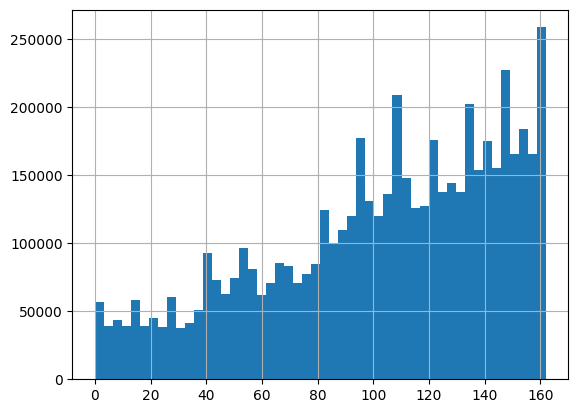

In [4]:
df.last_watch_dt.hist(bins=50)

In [5]:
train_df = df.loc[(df.last_watch_dt < 160-7)].copy()
test_df = df.loc[(df.last_watch_dt >= 160-7)].copy()

train_users = train_df.user_id.unique()
test_users = test_df.user_id.unique()

all_included = np.intersect1d(train_users, test_users)

print('число людей и там и там: ', all_included.shape[0])
print('число людей всего:', train_users.shape[0])

число людей и там и там:  134670
число людей всего: 880449


In [6]:
len(set(test_users) - set(train_users)) / len(test_users)

0.37768022181146027

И переведём всё к соединённому датасету:

In [7]:
n_users = 10000

all_included = np.random.choice(all_included, size=n_users, replace=False)

train_df = train_df.loc[train_df.user_id.isin(all_included)].copy()
test_df = test_df.loc[test_df.user_id.isin(all_included)].copy()

assert train_df.last_watch_dt.max() < test_df.last_watch_dt.min()
assert train_df.user_id.nunique() == n_users
assert test_df.user_id.nunique() == n_users

In [8]:
train_df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
58,739920,3190,145,3349,48.0
77,222359,11237,4,1714,31.0
119,10543,821,64,112,0.0
186,450102,3130,85,682,9.0
247,284039,9728,122,604,9.0


In [9]:
train_grouped = train_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                 x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
train_grouped.rename({0:'train_interactions'}, axis=1, inplace=True)

test_grouped = test_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                         x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
test_grouped.rename({0:'test_interactions'}, axis=1, inplace=True)

train_grouped.head()

/tmp/ipykernel_56978/1105526701.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_grouped = train_df.groupby('user_id').apply(
/tmp/ipykernel_56978/1105526701.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_grouped = test_df.groupby('user_id').apply(


,user_id,train_interactions
0,55,"[(9896, 15), (6192, 60), (3076, 99), (15297, 1..."
1,98,"[(2424, 15), (8314, 37), (142, 41), (6980, 41)..."
2,515,"[(3734, 114), (9728, 114), (4457, 115), (13865..."
3,565,"[(3734, 114), (15297, 114), (4151, 146)]"
4,571,"[(7149, 0), (10169, 5), (5931, 11), (4606, 11)..."


In [10]:
joined = train_grouped.merge(test_grouped)
joined.head()

,user_id,train_interactions,test_interactions
0,55,"[(9896, 15), (6192, 60), (3076, 99), (15297, 1...","[(14, 156)]"
1,98,"[(2424, 15), (8314, 37), (142, 41), (6980, 41)...","[(12360, 155), (89, 159), (512, 159)]"
2,515,"[(3734, 114), (9728, 114), (4457, 115), (13865...","[(512, 158), (6330, 158), (9811, 159), (14488,..."
3,565,"[(3734, 114), (15297, 114), (4151, 146)]","[(4260, 160)]"
4,571,"[(7149, 0), (10169, 5), (5931, 11), (4606, 11)...","[(4567, 156), (3071, 157), (14461, 159), (212,..."


In [11]:
np.random.seed(777)

class Random:

    def __init__(self):

        self.trained = False

    def fit(self, df, col='train_interactions'):

        items = set()
        for _, row in df.iterrows():
            for item, _ in row[col]:
                items.add(item)

        self.items = list(items)
        self.trained = True

    def predict(self, df, topn=10):
        assert self.trained
        return [np.random.choice(self.items, replace=False, size=topn)]*len(df)


random = Random()
random.fit(joined)

joined['random_recs'] = random.predict(joined, topn=3)
joined.head()

,user_id,train_interactions,test_interactions,random_recs
0,55,"[(9896, 15), (6192, 60), (3076, 99), (15297, 1...","[(14, 156)]","[3554, 11194, 10176]"
1,98,"[(2424, 15), (8314, 37), (142, 41), (6980, 41)...","[(12360, 155), (89, 159), (512, 159)]","[3554, 11194, 10176]"
2,515,"[(3734, 114), (9728, 114), (4457, 115), (13865...","[(512, 158), (6330, 158), (9811, 159), (14488,...","[3554, 11194, 10176]"
3,565,"[(3734, 114), (15297, 114), (4151, 146)]","[(4260, 160)]","[3554, 11194, 10176]"
4,571,"[(7149, 0), (10169, 5), (5931, 11), (4606, 11)...","[(4567, 156), (3071, 157), (14461, 159), (212,...","[3554, 11194, 10176]"


**Задание №1. Метрики и бейзлайны**

Добавьте реализацию метрик AP, RR, HR, их усреднённые версии по $U$ мы посчитаем ниже, если следовать коду с семинара, поэтому формулы немного отличаются. За имплементацию с циклами балл будет снижаться, векторизуйте! ( ͡° ͜ʖ ͡°)

$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$
p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)
$$
$$
RR@k = \dfrac{1}{\text{rank}_i@k}
$$
$$
HR@k = [\exists \ y_i = 1 \ \text{among k preds}]
$$


*   $n_u$ - число айтемов, с которыми взаимодействовал юзер $u$
*   $y_i$ - релевантно ли $i$-ое предсказание, $y_i \in \{0,1\}$
* $\text{rank}_i@k$ - позиция первого релеваннтого айтема среди первых $k$ предсказаний
* HR@k - среди первых $k$ предсказаний есть хотя бы одно релевантное

Считайте, что если `topn` не задано, то берётся всегда $n_u$. 

In [12]:
def ap_metric(gt_items: List[int], predictions: List[int], topn: Optional[int]=None) -> float:
    if topn is None:
        topn = len(predictions)
    predictions = predictions[:topn]
    hits = np.isin(predictions, gt_items).astype(int)
    precisions = np.cumsum(hits) / (np.arange(len(hits)) + 1)
    if hits.sum() == 0:
        return 0.0
    return (precisions * hits).sum() / min(len(gt_items), topn)

def rr_metric(gt_items: List[int], predictions: List[int], topn: Optional[int]=None) -> float:
    if topn is None:
        topn = len(predictions)
    predictions = predictions[:topn]
    for i, p in enumerate(predictions):
        if p in gt_items:
            return 1.0 / (i + 1)
    return 0.0

def hr_metric(gt_items: List[int], predictions: List[int], topn: Optional[int]=None) -> float:
    if topn is None:
        topn = len(predictions)
    predictions = predictions[:topn]
    return float(bool(set(predictions) & set(gt_items)))

Для вашего удобства в файле `metric_tests.py` есть тесты, но хардкодить их, разумеется, не стоит. 

In [13]:
run_tests(ap_metric, rr_metric, hr_metric)

В следующей ячейке код, который считает и усредняет метрики по юзерам. Он взят с семинара, при желании можно его тоже модифицировать, например, векторизовать. 

In [14]:
def evaluate_recommender(df, model_preds, gt_col='test_interactions'):

    metric_values = []

    for idx, row in df.iterrows():
        gt_items = [x[0] for x in row[gt_col]]
        predictions = row[model_preds]

        ap = ap_metric(gt_items, predictions)
        rr = rr_metric(gt_items, predictions)
        hr = hr_metric(gt_items, predictions)

        metric_values.append((ap, rr, hr))

    return {'map': np.mean([x[0] for x in metric_values]),
            'mrr': np.mean([x[1] for x in metric_values]),
            'hr': np.mean([x[2] for x in metric_values])}

Если вы всё сделали правильно, рандомные предсказания должны дать хоть какое-то качество, но не очень большое.

In [15]:
evaluate_recommender(joined, model_preds='random_recs')

{'map': np.float64(9.444444444444444e-05),
 'mrr': np.float64(0.0002666666666666666),
 'hr': np.float64(0.0006)}

In [16]:
class TopPopular:

    def __init__(self):

        self.trained = False

    def fit(self, df, col='train_interactions'):

        counts = {}
        for _, row in df.iterrows():
            for item, _ in row[col]:
                if item in counts:
                    counts[item] += 1
                else:
                    counts[item] = 1

        counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

        self.recommenations = [x[0] for x in counts]
        self.trained = True

    def predict(self, df, topn=10)  -> List[np.ndarray]:

        assert self.trained
        return [self.recommenations[:topn]]*len(df)


toppop = TopPopular()
toppop.fit(joined)

joined['toppopular_recs'] = toppop.predict(joined)
joined.head()

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs
0,55,"[(9896, 15), (6192, 60), (3076, 99), (15297, 1...","[(14, 156)]","[3554, 11194, 10176]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
1,98,"[(2424, 15), (8314, 37), (142, 41), (6980, 41)...","[(12360, 155), (89, 159), (512, 159)]","[3554, 11194, 10176]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
2,515,"[(3734, 114), (9728, 114), (4457, 115), (13865...","[(512, 158), (6330, 158), (9811, 159), (14488,...","[3554, 11194, 10176]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
3,565,"[(3734, 114), (15297, 114), (4151, 146)]","[(4260, 160)]","[3554, 11194, 10176]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
4,571,"[(7149, 0), (10169, 5), (5931, 11), (4606, 11)...","[(4567, 156), (3071, 157), (14461, 159), (212,...","[3554, 11194, 10176]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."


Самые популярные предсказания должны показать более высокое качество.

In [17]:
evaluate_recommender(joined, model_preds='toppopular_recs')

{'map': np.float64(0.06600374281934995),
 'mrr': np.float64(0.11801492063492064),
 'hr': np.float64(0.2695)}

**Задание №2. Рекомендации в окне**

Здесь необходимо переделать метод рекомендации по популярности так, что популярность считается только за какое-то более свежее временное окно. Под окном подразумевается какой-то временной промежуток, например, ближайший месяц. Соответственно, всё что за его пределами, не учитывается.

In [18]:
class TopPopularWeighted(TopPopular):

    def __init__(self, min_window=2):
        super().__init__()
        self.min_window = min_window

    def fit(self, df, col='train_interactions'):
        counts = {}
        current_time = df[col].apply(lambda x: max([t[1] for t in x])).max()

        for _, row in df.iterrows():
            for item, timestamp in row[col]:
                # Проверка, входит ли дата в окно
                if current_time - timestamp <= self.min_window:
                    if item in counts:
                        counts[item] += 1
                    else:
                        counts[item] = 1

        counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

        self.recommenations = [x[0] for x in counts]
        self.trained = True

Теперь постройте графики зависимости значений трёх метрик (AP@k, RR@k, HR@k) от размера окна. 

In [19]:
results = {
    'window_size': [],
    'map': [],
    'mrr': [],
    'hr': []
}

window_sizes = [1, 2, 5, 7, 14, 30, 60, 90]

for window_size in window_sizes:
    model = TopPopularWeighted(min_window=window_size)
    model.fit(joined)

    joined['weighted_recs'] = model.predict(joined)

    # Рассчитываем метрики
    metrics = evaluate_recommender(joined, model_preds='weighted_recs')

    # Сохраняем результаты
    results['window_size'].append(window_size)
    results['map'].append(metrics['map'])
    results['mrr'].append(metrics['mrr'])
    results['hr'].append(metrics['hr'])


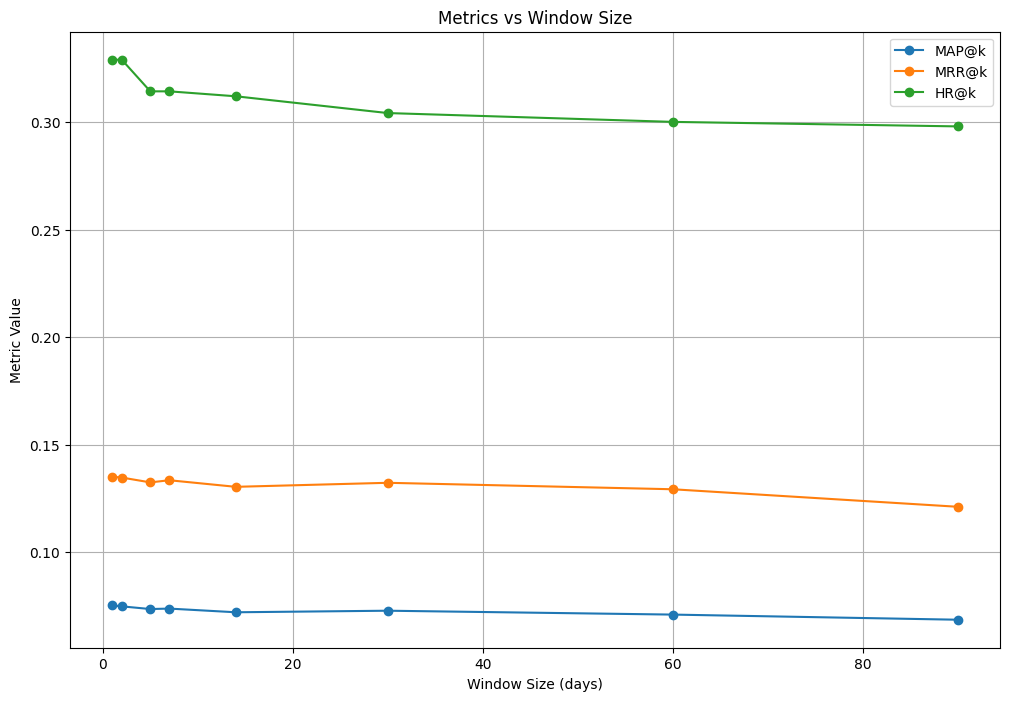

In [20]:
plt.figure(figsize=(12, 8))
plt.plot(results['window_size'], results['map'], label='MAP@k', marker='o')
plt.plot(results['window_size'], results['mrr'], label='MRR@k', marker='o')
plt.plot(results['window_size'], results['hr'], label='HR@k', marker='o')
plt.xlabel('Window Size (days)')
plt.ylabel('Metric Value')
plt.title('Metrics vs Window Size')
plt.legend()
plt.grid(True)
plt.show()

Подумайте и ответьте, как размер окна влияет на качество рекомендаций. Какое значение наилучшее, есть ли у этого разумное объяснение?

**Ответ:**

Если выбрать маленькое окно, оно будет хорошо отрожать последние изменения в среде. Т.е. хорошо подходит и к очень диномичной нише. Где постоянно все меняется.  
  
Окно с большим шагом позволяет охватывать больше данных и затрагивать исторические данные. Хорошо будет подходить для рекомендаций где есть наколпление знаний, например рекомендации фильмов, книг и т.п. как правильно, люди склонны формировать свой шаблон, исторические данные хорошо в этом помогают  
  
На основании графиков, оптимально выбрать окно 2

**Задание №3. Метрики и k.**

Постройте зависимость значений MAP@K, MRR@K, HR@K для метода рекомендации по популярности. Возьмите какие-нибудь k, например, от 1 до 100, переберите значения и покажите на линейном графике. 

In [21]:
joined['toppopular_recs'] = toppop.predict(joined, topn=100)

In [22]:
results_topk = {
    'topk': [],
    'map': [],
    'mrr': [],
    'hr': []
}

top_k_values = range(1, 101, 5)
for k in top_k_values:
    toppop_k = TopPopular()
    toppop_k.fit(joined)

    joined['toppopular_recs'] = toppop_k.predict(joined, topn=k)

    metrics = evaluate_recommender(joined, model_preds='toppopular_recs')
    results_topk['topk'].append(k)
    results_topk['map'].append(metrics['map'])
    results_topk['mrr'].append(metrics['mrr'])
    results_topk['hr'].append(metrics['hr'])

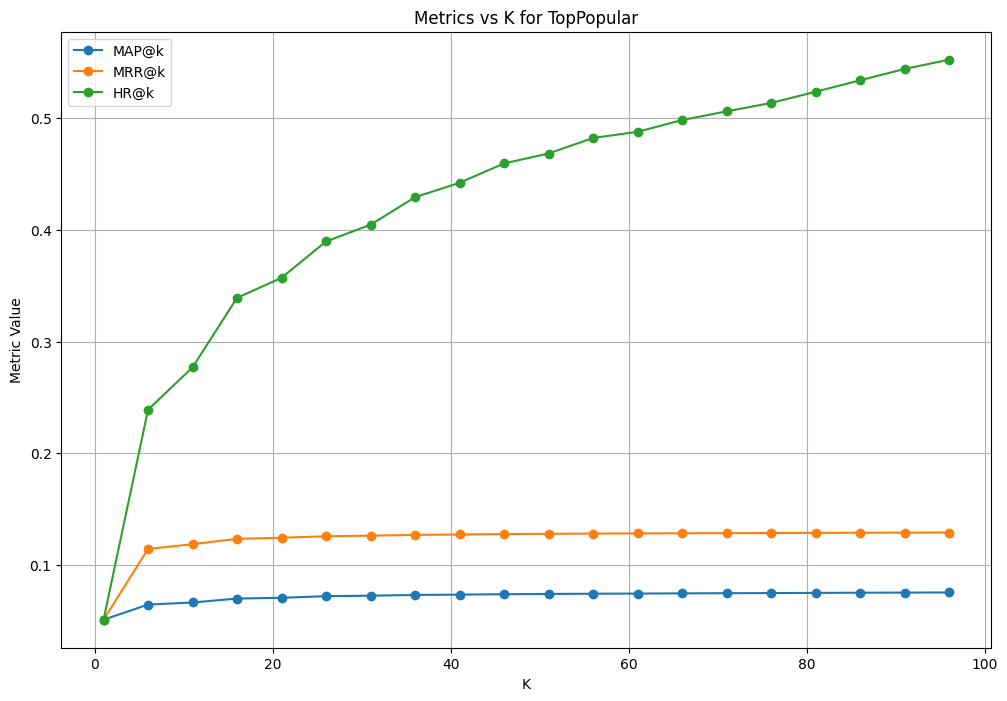

In [23]:
plt.figure(figsize=(12, 8))
plt.plot(results_topk['topk'], results_topk['map'], label='MAP@k', marker='o')
plt.plot(results_topk['topk'], results_topk['mrr'], label='MRR@k', marker='o')
plt.plot(results_topk['topk'], results_topk['hr'], label='HR@k', marker='o')
plt.xlabel('K')
plt.ylabel('Metric Value')
plt.title('Metrics vs K for TopPopular')
plt.legend()
plt.grid(True)
plt.show()

Хорошенько подумайте и ответьте на вопросы ниже.

3.1 Какие из метрик являются монотонными функциями по top-K? Объясните, почему они являются монотонными? \
**Ответ:**
HR@K - Монотонная от top_k, чем больше взяли k тем более вероятно, что что0то релевантное попадет к нам в выборку  
MAP@K - на основании цифр, монотонна но сильно более полога чем предидущая. Аналогично с прошлой метрикой по вероятности, это также будет сказываться на точности, чем больше выборка, тем более вероятно что мы точно найдем то что нам нужно.  
MRR@K - не монотонная, т.к. нам нужен ранг 1 в рекомендации. Но если нам нужна рекомендация сильно ниже, то топ к может изменить вид зависимости.  

3.2 Объясните по каждой метрике, как можно интерпретировать ее график? То есть, что можно сказать про связь изменения метрики c возможными пользовательскими сценариями, например,скроллингом ленты новостей. \
**Ответ:**
HR@K - отражает вероятность найти что-то интересующее пользователя из предложенного, чем больше показали, тем более вероятно что попадем в то, что нужно. Хорошо подходит для диномичных списков, где пользователь не тратит много времени на анализ 1-ого компанента предложенных объектов.
MAP@K - отражает вероятность того, что мы покажем пользователю то, что его точно заинтересует. Хорошо подходит для рекомендаций, где внимание пользователя подает как распределение Пуассона, т.е, чем дольше пользователь гартает рекомендации, теме менее вероятно что он выберет что-то даже если есму это нужно.  
MRR@K - показывает как высоко наша релевантная для пользователя рекомендация в списке. 

3.3 Как вы думаете, почему графики выглядят именно так? Должны ли они возрастать/убывать, от чего это может зависеть? (Тут вам может помочь дополнительный анализ данных)\
**Ответ:**
HR@K - логично, что чем больше стрелять по мишени, тем выше вероятность что хоть раз но попадем.  
MAP@K - тут вопрос, про то как хорошо работает наша система рекомендаций. Если мы имеем идеальную систему, где всегда выдаем, то что нужно, то график будет константный.  
MRR@K - вопрос постановки задачи. Если рассматривать с точки зрения всегда давать то что нужно, то от топ к мало зависит. Но если посмотреть на задачу удержания пользователя онлайн, то уже будет по другому выглядеть, например есть хороший "Пример" сайты знакомств, они зарабатывают на рекламе, и им нужно как можно дольше держать пользователя онлайн, и ходить по грани, готов уйти с сайта => заинтересуем и дадим что ему нужно. Тут график будет более сильно зависеть от топ к

**Задание №4. Интерпретация рейтингов**

Возьмите названия фильмов/сериалов из `items.csv`, выделите 5 различных сценариев изменения популярности у фильмов, аргументируйте (например, графиком или статистикой) и проинтерпретируейте их (почему популярность для этого фильма меняется так). Обратите внимание, что надо найти именно разные паттерны изменения вероятностей. 

In [24]:
items = pd.read_csv('items.csv')[['item_id','title']].copy()
items.head()

,item_id,title
0,10711,Поговори с ней
1,2508,Голые перцы
2,10716,Тактическая сила
3,7868,45 лет
4,16268,Все решает мгновение


Пример:

1917


<Axes: >

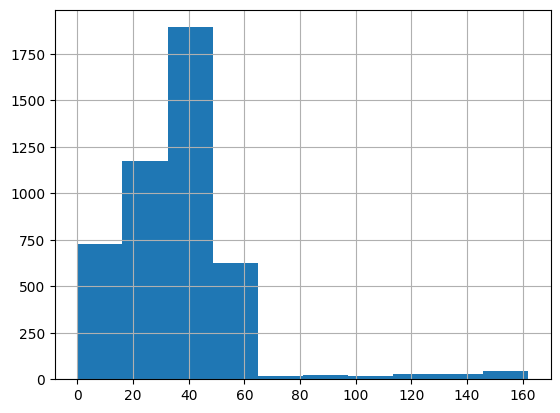

In [25]:
popular_items = df.item_id.value_counts()[:300].index.tolist()
sampled_id = np.random.choice(popular_items)

# это для примера, хотя выцеплять случаи по одному может быть не лучшей идеей
sampled_id = 3402

interactions = df.loc[df.item_id==sampled_id].copy()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(name)
interactions.last_watch_dt.hist()

Фильм 1917 какое-то время набирал популярность, потом видим резкое падение (кстати, с какой даты?). Возможно, это связано с ограничением доступности этого фильма для части пользователей, периодом проката фильма / рекламной кампании или другой причиной. 

Добавьте 5 своих примеров ниже. Опишите, как вы их искали. 

In [26]:
def plot_item_popularity(item_id, df):
    interactions = df.loc[df.item_id == item_id].copy()
    name = items_df.loc[items_df.item_id == item_id, 'title'].values[0]
    interactions.last_watch_dt.hist(bins=30)
    plt.title(f'Popularity of "{name}" Over Time')
    plt.xlabel('Days')
    plt.ylabel('Interactions')
    plt.show()

items_df = pd.read_csv('items.csv')[['item_id', 'title']]

In [27]:
popular_items = df.item_id.value_counts()[df.item_id.value_counts() > 1000].index.tolist()

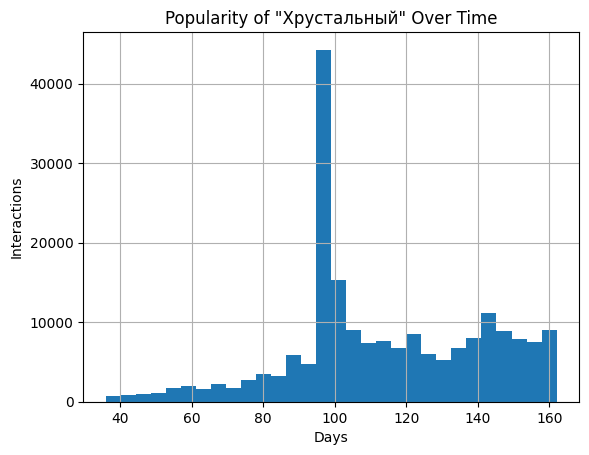

In [28]:
plot_item_popularity(popular_items[0], df)
# монотонно набирает кол-во просмотров, но есть яркий пик, может быть кто-то отрекламировал или просто "хайпанул"

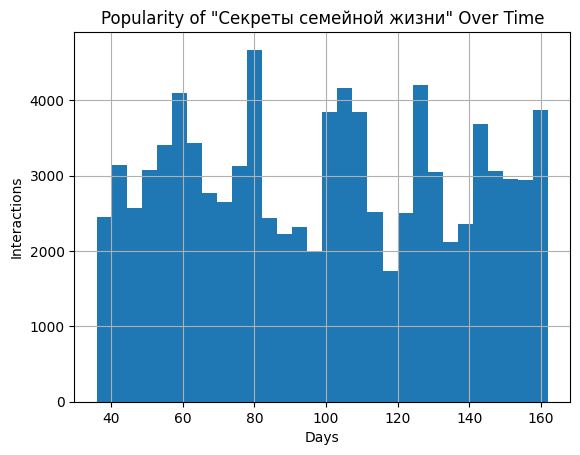

In [29]:
plot_item_popularity(popular_items[4], df)
# обычная ситуация, где +- в среднем дежится по просмотрам, но со временем должен уходить вних и потом на плато

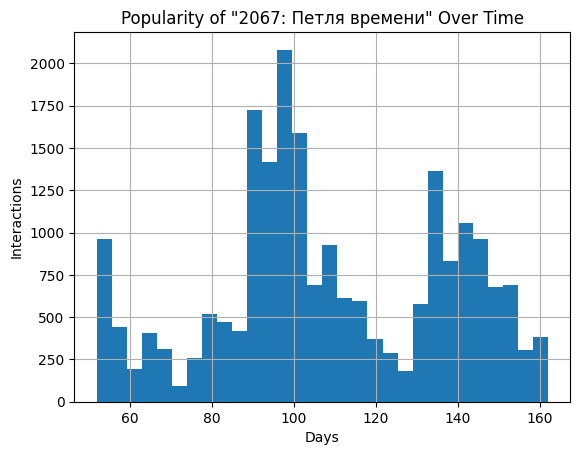

In [30]:
plot_item_popularity(popular_items[18], df)
# наличие нескольких пиков. Мб обзоры кто-то делает и т.п.

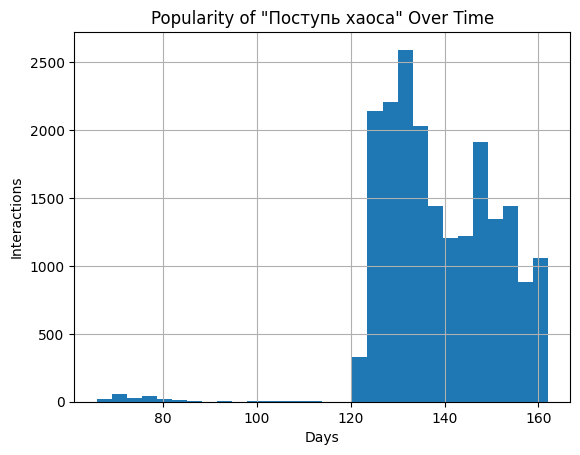

In [31]:
plot_item_popularity(popular_items[22], df)
# резкий бум в просмотрете, хайп или что-то вроде этого.

**Задание №5. User-item encoding**

Теперь, создайте матрицу интеракций user-item по примеру из семинара. Вам нужно в итоге получить разреженную матрицу (sparse matrix), в которой в качестве строк будут пользователи, в качестве колонок - айтемы. Не забудьте перекодировать пользователей и айтемы через энкодер. В отличие от семинара, оставьте в матрице только юзеров и айтемы, которые встречались в матрице > 4 раз.

Важно: когда вы отфильтруете юзеров на встречаемость > 4 раз, вы удалите какие-то айтемы, которые теперь станут встречаться меньше 5 раз. Поэтому у вас перестанет выполняться второе условие на минимальное число интеракций с айтемом. Тогда вам надо опять отфильтровать айтемы на встречаемость, но это снова может нарушить условие для юзеров. В таком случае, вам надо написать итеративный алгоритм до сходимости, пока требования не будут выполняться в обеих колонках. 

In [32]:
def filter_column(df, col, min_freq):
    """
    Filter dataframe, excluding least active users and least popular items.
    Return a copy of the dataframe with at least min_freq entries
    in both users and items
    """
    counts = df[col].value_counts()
    return df[df[col].isin(counts[counts >= min_freq].index)]

def filter_dataframe(df, cols, min_freq=5):
    """
    Filter dataframe by given columns until each of them satisfies
    min_freq condition, guaranteed by filter_columns. Return a copy
    of the dataframe
    """
    prev_shape = None
    current_shape = df.shape
    while prev_shape != current_shape:
        prev_shape = current_shape
        for col in cols:
            df = filter_column(df, col, min_freq)
        current_shape = df.shape
    return df

filtered_train = filter_dataframe(train_df, ['user_id', 'item_id'], min_freq=5)

In [33]:
def df_encode(df):
    item2id = {k:v for v, k in enumerate(df.item_id.unique())}
    user2id = {k:v for v, k in enumerate(df.user_id.unique())}

    df['user_id'] = df.user_id.apply(lambda x: user2id[x])
    df['item_id'] = df.item_id.apply(lambda x: item2id[x])
    return df, item2id, user2id

filtered_train, item2id, user2id = df_encode(filtered_train)

id2item = {v: k for k, v in item2id.items()}
id2user = {v: k for k, v in user2id.items()}
filtered_train.sample(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
2274006,1991,1140,80,5783,87.0
4161529,1487,1489,59,19861,100.0
3090989,1510,1697,145,7956,100.0
3404962,1620,141,41,2991,46.0
2016565,1557,34,152,4400,66.0


In [34]:
from scipy import sparse as sps

matrix = sps.coo_matrix(
    (np.ones(filtered_train.shape[0]), (filtered_train['user_id'], filtered_train['item_id'])),
    shape=(len(user2id), len(item2id)),
)
matrix

<COOrdinate sparse matrix of dtype 'float64'
	with 105578 stored elements and shape (5888, 3049)>

**Задание №6. Интеракции и частота**

Постройте график зависимости количества айтемов и юзеров от значений (порогов) фильтров на встречаемость в матрице интеракций. То есть, нужно выполнить задание №5 для нескольких значений `min_freq` и построить график зависимости числа оставшихся айтемов и юзеров от этого параметра. 

In [35]:
user_counts = []
item_counts = []
freq_values = range(1, 21, 2)

for min_freq in freq_values:
    filtered_train = filter_dataframe(train_df, ['user_id', 'item_id'], min_freq=min_freq)

    user_counts.append(filtered_train['user_id'].nunique())
    item_counts.append(filtered_train['item_id'].nunique())

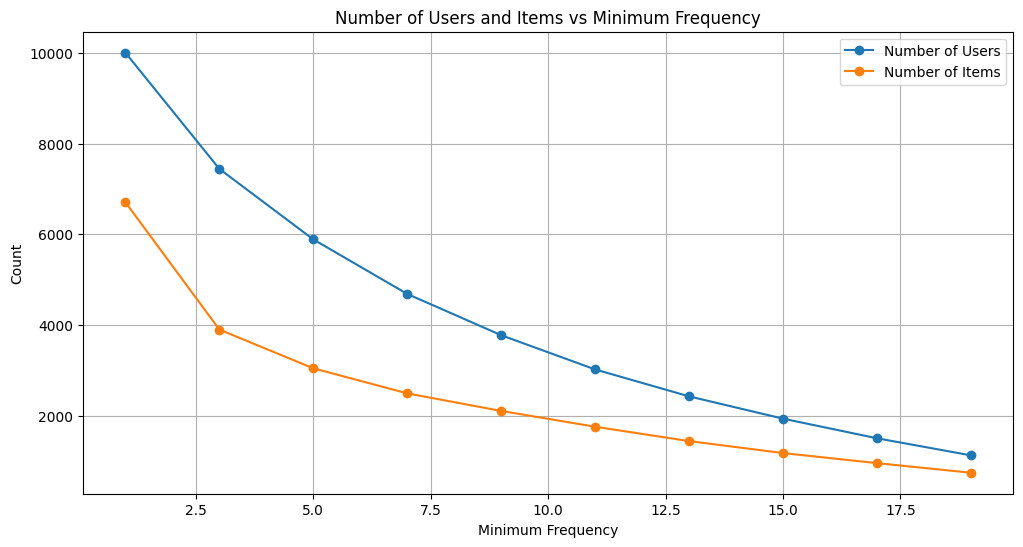

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(freq_values, user_counts, label='Number of Users', marker='o')
plt.plot(freq_values, item_counts, label='Number of Items', marker='o')
plt.xlabel('Minimum Frequency')
plt.ylabel('Count')
plt.title('Number of Users and Items vs Minimum Frequency')
plt.legend()
plt.grid(True)
plt.show()

**Задание №7. EASE**

Реализуйте EASE, постройте рекомендации для юзеров. Сравните все имплементированные ранее метрики качества с `TopPopular` для некоторого набора k. 

Реализацию можно взять из семинара. Можно реализовать по статье https://arxiv.org/pdf/1905.03375.pdf. Можно взять и адаптировать из RecBole https://github.com/RUCAIBox/RecBole.

In [37]:
%%time

# Обучаем конечную модель
# Мы взяли реализацию из RecBole
#
def fit_ease(X, reg_weight=1000):
    """ Fit the EASE model """

    X = X.tocsr()
    G = X.T @ X
    G = G.toarray()
    diag_indices = np.diag_indices_from(G)
    G[diag_indices] += reg_weight
    P = np.linalg.inv(G)
    B = P / (-np.diag(P))
    B[diag_indices] = 0
    return B

w = fit_ease(matrix)

CPU times: user 2.98 s, sys: 94.5 ms, total: 3.08 s
Wall time: 1.93 s


Далее, вам надо реализовать функцию получения предсказаний. У вас есть обученная матрица весов, которую можно использовать для получения предсказаний. Для этого нужно построить вектор интеракций пользователя и умножить его на матрицу весов.

In [38]:
x = joined.train_interactions.loc[0]

In [39]:
user_vector = np.zeros(len(item2id))
for item_id, _ in x:
    if item_id in item2id:
        user_vector[item2id[item_id]] = 1

In [40]:
scores = user_vector @ w

In [41]:
seen_items = set(item2id[item_id] for item_id, _ in x if item_id in item2id)

In [42]:
scores[list(seen_items)] = -np.inf

In [43]:
def get_preds(x, item2id, id2item, w, topn=10):

    user_vector = np.zeros(len(item2id))
    for item_id, _ in x:
        if item_id in item2id:
            user_vector[item2id[item_id]] = 1

    scores = user_vector @ w


    seen_items = set(item2id[item_id] for item_id, _ in x if item_id in item2id)
    scores[list(seen_items)] = -np.inf
    top_items = np.argsort(scores)[-topn:][::-1]
    decoded = [id2item[item] for item in top_items if item in id2item]

    return decoded


joined['ease_preds'] = joined.train_interactions.apply(lambda x: get_preds(x, item2id, id2item, w))
joined.head()

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs,weighted_recs,ease_preds
0,55,"[(9896, 15), (6192, 60), (3076, 99), (15297, 1...","[(14, 156)]","[3554, 11194, 10176]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[10440, 15297, 9728, 13865, 3734, 4151, 2657, ...","[10440, 9728, 3734, 142, 4880, 12192, 13865, 2..."
1,98,"[(2424, 15), (8314, 37), (142, 41), (6980, 41)...","[(12360, 155), (89, 159), (512, 159)]","[3554, 11194, 10176]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[10440, 15297, 9728, 13865, 3734, 4151, 2657, ...","[13865, 15297, 10440, 9728, 9996, 4151, 2657, ..."
2,515,"[(3734, 114), (9728, 114), (4457, 115), (13865...","[(512, 158), (6330, 158), (9811, 159), (14488,...","[3554, 11194, 10176]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[10440, 15297, 9728, 13865, 3734, 4151, 2657, ...","[10440, 4151, 4880, 142, 8636, 2657, 12192, 12..."
3,565,"[(3734, 114), (15297, 114), (4151, 146)]","[(4260, 160)]","[3554, 11194, 10176]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[10440, 15297, 9728, 13865, 3734, 4151, 2657, ...","[10440, 4880, 13865, 9728, 2657, 142, 12192, 1..."
4,571,"[(7149, 0), (10169, 5), (5931, 11), (4606, 11)...","[(4567, 156), (3071, 157), (14461, 159), (212,...","[3554, 11194, 10176]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[10440, 15297, 9728, 13865, 3734, 4151, 2657, ...","[13865, 15297, 9728, 9996, 2657, 4151, 3734, 4..."


In [44]:
ease_metrics = evaluate_recommender(joined, model_preds='ease_preds')
toppop_metrics = evaluate_recommender(joined, model_preds='toppopular_recs')

In [45]:
print("EASE Metrics:", ease_metrics)
print("TopPopular Metrics:", toppop_metrics)

EASE Metrics: {'map': np.float64(0.08563669286974049), 'mrr': np.float64(0.15719123015873016), 'hr': np.float64(0.3296)}
TopPopular Metrics: {'map': np.float64(0.07546652585884937), 'mrr': np.float64(0.12911333443812978), 'hr': np.float64(0.5521)}


Сделайте выводы — какой алгоритм работает лучше?

**Ответ:**
EASE - лучше работает если важны ранжирование и точность  
TopPopular - лучше работает если важна полнота. 

**Задание №8. Тюнинг**

Переберите различные значения гиперпараметра коэффициента регуляризации у EASE и постройте графики, как в задании №6. Постарайтесь "затюнить" EASE как можно лучше. Возьмите разумное число гиперпараметров - хотя бы штук 20 по логарифмической сетке, либо используйте более хитрые алгоритмы оптимизации. 

In [47]:
reg_values = np.logspace(0, 4, 20)

results = {
    'reg_weight': [],
    'map': [],
    'mrr': [],
    'hr': []
}

for reg in reg_values:
    w = fit_ease(matrix, reg_weight=reg)

    joined['ease_preds'] = joined['train_interactions'].apply(lambda x: get_preds(x, item2id, id2item, w))

    metrics = evaluate_recommender(joined, model_preds='ease_preds')
    
    results['reg_weight'].append(reg)
    results['map'].append(metrics['map'])
    results['mrr'].append(metrics['mrr'])
    results['hr'].append(metrics['hr'])

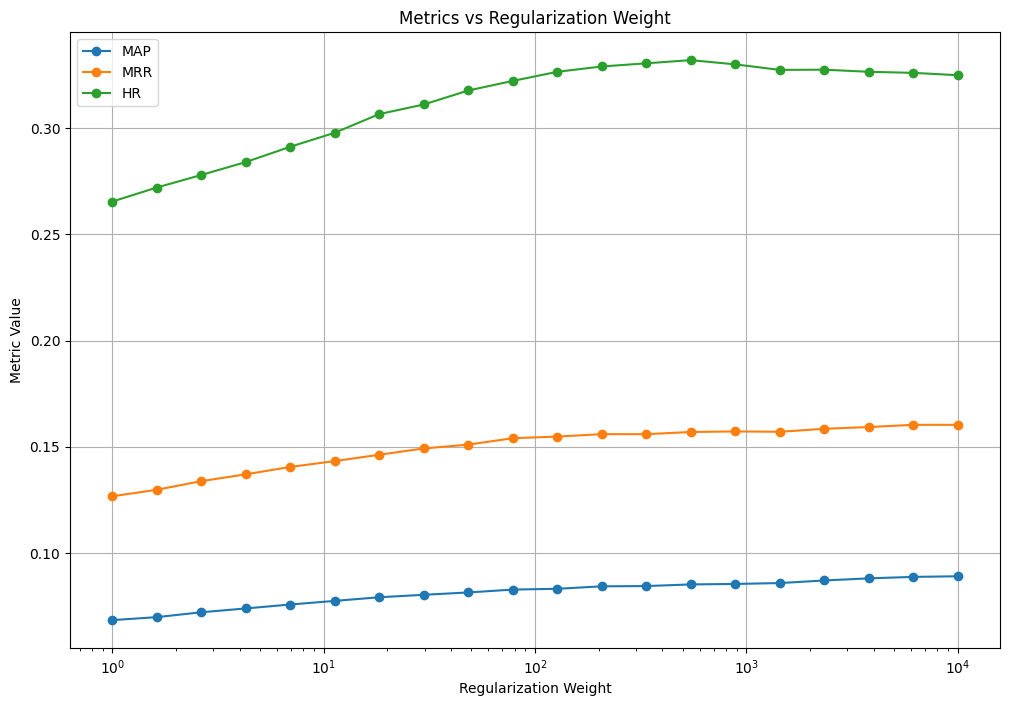

In [48]:
plt.figure(figsize=(12, 8))
plt.plot(results['reg_weight'], results['map'], label='MAP', marker='o')
plt.plot(results['reg_weight'], results['mrr'], label='MRR', marker='o')
plt.plot(results['reg_weight'], results['hr'], label='HR', marker='o')
plt.xscale('log')
plt.xlabel('Regularization Weight')
plt.ylabel('Metric Value')
plt.title('Metrics vs Regularization Weight')
plt.legend()
plt.grid(True)
plt.show()

Ответьте на следующие вопросы:

8.1 Какое значение гиперпараметра является наилучшим? 


**Ответ:**
reg_weight > 1000 выглядит стабильным для всех метрик, поэтому данный параметр оптимален если нужны высокие и стабильные качества на всех метриках. Если нужна конкретная метрика то нужно смотреть более детально.  

8.2 Что еще интересного вы можете сказать по графикам? Может быть, что-то свзяанное с распределением параметров, влиянием на отдельные метрики, скоростью тюнинга?

**Ответ:**

Регулризация помогает поднять качества, но до определенного предела, с некоторого порога регуляризация не вносит значимх изменений. Также метрики для конкретно нашего случая стабилизируются в одном окне значений, что хорошо. Степень влияния на метрики различна. Из графика видно, что на HR влияние сильнее чем на другие метрики. Скорость тюнинга падает по мере увеличения веса регуляризатора. 

**Задание №9. EASE и topk**

В лекции №2 говорилось, что качество у EASE растет с ослаблением фильтра на число айтемов. В этом задании постройте кривые метрик качества MAP/MRR/HR в зависимости от topk (например, от 1 до 100 с некоторым шагом), где кривая параметризована минимальным требуемым значением встречаемости user/item (из задания №6). Опишите свои выводы.

Важно: в этом задании линии могут быть мало различимыми, поэтому ваша задача для каждой метрики найти нужный масштаб на каких-то конкретных topk, чтобы линии стали визуально отличимы. 

In [50]:
top_k_values = [1, 5, 10, 15]
min_freq_values = [1, 5, 10, 15]

results = {min_freq: {'map': [], 'mrr': [], 'hr': []} for min_freq in min_freq_values}

for min_freq in min_freq_values:
    filtered_train = filter_dataframe(train_df, ['user_id', 'item_id'], min_freq=min_freq)
    filtered_train, item2id, user2id = df_encode(filtered_train)
    matrix = sps.coo_matrix(
        (np.ones(filtered_train.shape[0]), (filtered_train['user_id'], filtered_train['item_id'])),
        shape=(len(user2id), len(item2id)),
    )
    w = fit_ease(matrix)

    for k in top_k_values:
        joined['ease_preds'] = joined['train_interactions'].apply(lambda x: get_preds(x, item2id, id2item, w, topn=k))
        metrics = evaluate_recommender(joined, model_preds='ease_preds')
        
        # Сохраняем результаты
        results[min_freq]['map'].append(metrics['map'])
        results[min_freq]['mrr'].append(metrics['mrr'])
        results[min_freq]['hr'].append(metrics['hr'])
        print(f'DONE: min_freq={min_freq} and top_k_values={k}')

DONE: min_freq=1 and top_k_values=1
DONE: min_freq=1 and top_k_values=5
DONE: min_freq=1 and top_k_values=10
DONE: min_freq=1 and top_k_values=15
DONE: min_freq=5 and top_k_values=1
DONE: min_freq=5 and top_k_values=5
DONE: min_freq=5 and top_k_values=10
DONE: min_freq=5 and top_k_values=15
DONE: min_freq=10 and top_k_values=1
DONE: min_freq=10 and top_k_values=5
DONE: min_freq=10 and top_k_values=10
DONE: min_freq=10 and top_k_values=15
DONE: min_freq=15 and top_k_values=1
DONE: min_freq=15 and top_k_values=5
DONE: min_freq=15 and top_k_values=10
DONE: min_freq=15 and top_k_values=15


In [52]:
metric

'hr'

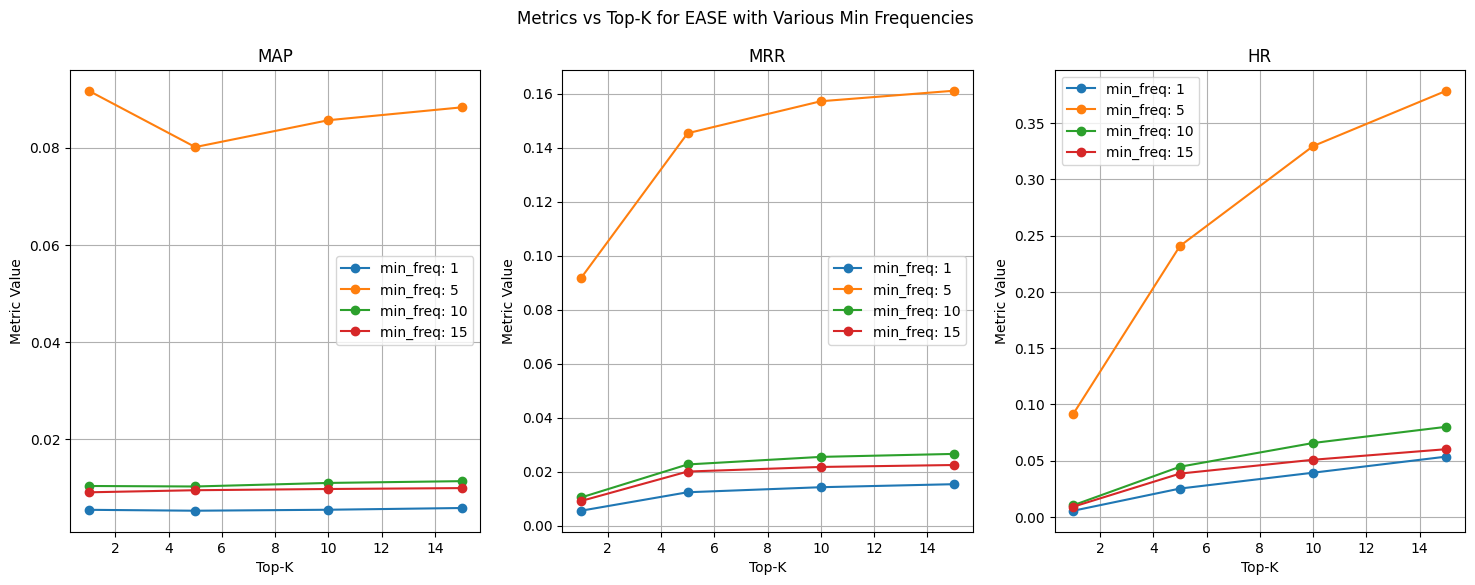

In [53]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True)

for i, metric in enumerate(['map', 'mrr', 'hr']):
    for min_freq in min_freq_values:
        axes[i].plot(top_k_values, results[min_freq][metric], label=f'min_freq: {min_freq}', marker='o')
    axes[i].set_title(metric.upper())
    axes[i].set_xlabel('Top-K')
    axes[i].set_ylabel('Metric Value')
    axes[i].legend()
    axes[i].grid(True)

plt.suptitle('Metrics vs Top-K for EASE with Various Min Frequencies')
plt.show()

Что вы можете сказать на основе полученных графиков? Соответствуют ли они вашим ожиданиям?

**Ответ:**  
Луший min_freq = 5, остальные значительно уступают, как больше, так и меньше.  
HR возрастает с увеличением top-K. Это логично, так как пользователю предлагается больше вариантов для выбора.  
Повышение min_freq до 5 показывает улучшение во всех трех метриках  
min_freq = 10 и 15 метрики также улучшаются, они не достигают уровня min_freq = 5, что может свидетельствовать о том, что слишком строгая фильтрация уменьшает количество данных, необходимых для обучения

**Задание №10. Интерпретируемые рекомендации**

Используйте выученную матрицу весов для item2item рекомендаций. Приведите 10 примеров топ-5 рекомендаций от EASE к сэмплируемым айтемам. Используйте названия фильмов вместо id при выводе рекомендаций. 

In [54]:
def get_item_recommendations(item_id, w, item2id, id2item, topn=5):
    item_idx = item2id.get(item_id, None)
    if item_idx is None:
        return []

    item_weights = w[item_idx]

    similar_items = np.argsort(item_weights)[-topn-1:-1][::-1]
    
    recommendations = [id2item[idx] for idx in similar_items]
    return recommendations

In [55]:
item_titles = items.set_index('item_id')['title'].to_dict()

In [56]:
sampled_items = np.random.choice(list(item2id.keys()), size=10, replace=False)

In [57]:
for item_id in sampled_items:
    recommendations = get_item_recommendations(item_id, w, item2id, id2item)
    print(f"Фильм: {item_titles.get(item_id, 'Неизвестный')}")
    print("Рекомендуемые фильмы:")
    for rec_id in recommendations:
        print(f"- {item_titles.get(rec_id, 'Неизвестный')}")
    print()

Фильм: Абсолютное зло
Рекомендуемые фильмы:
- Пираты по соседству
- Опасное погружение
- Перл Харбор
- Секс и ничего лишнего
- Маша и Медведь

Фильм: Человек-паук: Через вселенные
Рекомендуемые фильмы:
- Значит, война
- Проклятие ведьмы
- Мой домашний динозавр
- Игра лжецов
- Человек, который спас мир

Фильм: Обитель зла: Возмездие
Рекомендуемые фильмы:
- Король Артур
- Милашка как ты
- Ледниковый период 3: Эра динозавров
- Привет, Монстр
- Самый жестокий год

Фильм: Невероятный Халк
Рекомендуемые фильмы:
- Doom: Аннигиляция
- Ледниковый период 3: Эра динозавров
- Чёрный лебедь
- Дикие предки
- Опасное погружение

Фильм: Чужой: Завет
Рекомендуемые фильмы:
- Планета обезьян: Революция
- Обитель зла 4: Жизнь после смерти 
- Рататуй
- 9 месяцев
- Великий

Фильм: Альфа
Рекомендуемые фильмы:
- Гнев человеческий
- Зверь
- Кротик и Панда
- Жизнь вне Земли
- Джой

Фильм: Люди Икс: Тёмный Феникс
Рекомендуемые фильмы:
- Милашка как ты
- Корова
- Металионы
- Чёрный лебедь
- [4К] Дорога чести

Фил

Хорошие ли получились рекомендации? Почему? Есть ли хорошие примеры? Есть ли плохие? Почему бывают плохие примеры?

**Ответ:**  
Есть как хорошие, так и плохие рекомендации, на основании моей субъективной точки зрения. 
Плохие примеры бывают из за недообученности модели, мало данных, шум и т.п.